Importing required library

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path = "mnist.npz")

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
from keras.preprocessing import image

Preprocessing the Images

In [4]:
x_train = x_train/255
x_test = x_test/255
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print(x_train.shape)

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
print(y_train.shape)

(60000, 28, 28, 1)
(60000, 10)


Designing the CNN model

In [5]:
model = tf.keras.Sequential()

In [6]:
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, activation = "relu", input_shape = (28, 28, 1), padding = "same"))

In [7]:
model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, activation = "relu", padding = "same"))

In [8]:
model.add(tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, activation = "relu", padding = "same"))

In [9]:
model.add(tf.keras.layers.Conv2D(filters = 512, kernel_size = 3, activation = "relu", padding = "same"))

In [10]:
model.add(tf.keras.layers.GlobalAveragePooling2D())

In [11]:
model.add(tf.keras.layers.Dense(units = 10, activation = "softmax"))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 512)       1180160   
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                5130      
Total params: 1,554,954
Trainable params: 1,554,954
Non-trainable params: 0
______________________________________________

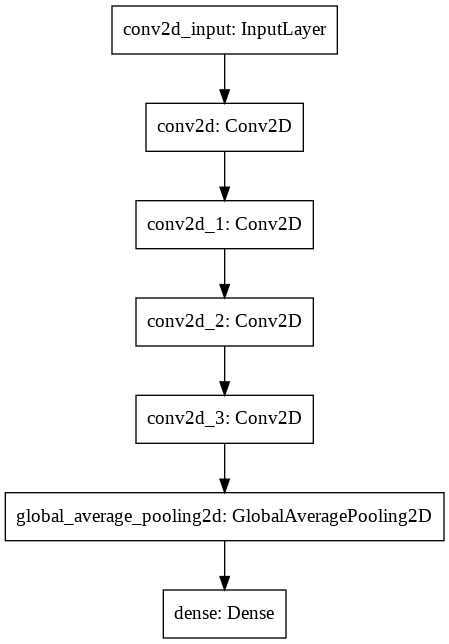

In [13]:
from keras.utils import plot_model
plot_model(model)

Compiling the model

In [14]:
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

Training and validation

In [15]:
model.fit(x_train, y_train, batch_size = 32, epochs = 15, validation_split = 0.2)

Epoch 1/15
1500/1500 [==============================] - 77s 29ms/step - loss: 1.0518 - accuracy: 0.6211 - val_loss: 0.2484 - val_accuracy: 0.9217
Epoch 2/15
1500/1500 [==============================] - 44s 30ms/step - loss: 0.1679 - accuracy: 0.9507 - val_loss: 0.1283 - val_accuracy: 0.9618
Epoch 3/15
1500/1500 [==============================] - 44s 30ms/step - loss: 0.1080 - accuracy: 0.9666 - val_loss: 0.0708 - val_accuracy: 0.9793
Epoch 4/15
1500/1500 [==============================] - 44s 30ms/step - loss: 0.0862 - accuracy: 0.9742 - val_loss: 0.0618 - val_accuracy: 0.9809
Epoch 5/15
1500/1500 [==============================] - 44s 29ms/step - loss: 0.0659 - accuracy: 0.9798 - val_loss: 0.0598 - val_accuracy: 0.9819
Epoch 6/15
1500/1500 [==============================] - 44s 29ms/step - loss: 0.0561 - accuracy: 0.9835 - val_loss: 0.0782 - val_accuracy: 0.9755
Epoch 7/15
1500/1500 [==============================] - 44s 29ms/step - loss: 0.0481 - accuracy: 0.9850 - val_loss: 0.0539 -

In [16]:
# Validation accuracy
score = model.evaluate(x_test, y_test, verbose = 1)
print(score)

313/313 [==============================] - 4s 11ms/step - loss: 0.0301 - accuracy: 0.9912
[0.030089305713772774, 0.9911999702453613]


Implementing CAM

In [17]:
# Designing a model to get feature map and the results
from keras.models import Model
cam = Model(inputs = model.input, outputs = (model.layers[-3].output, model.layers[-1].output))

In [18]:
cam.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 512)       1180160   
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                5130  

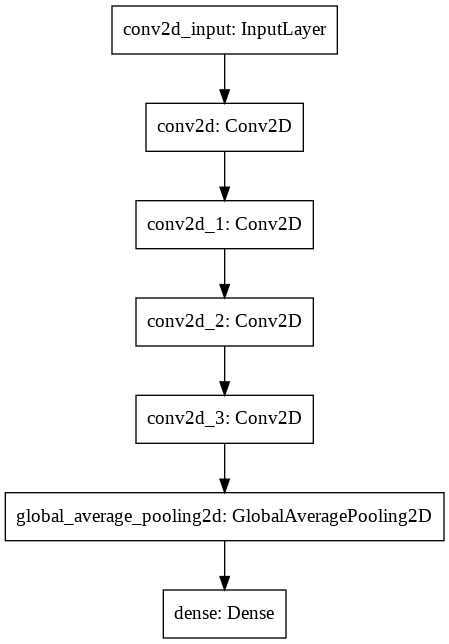

In [19]:
plot_model(cam)

In [24]:
# Implemeting relu
def relu(x):
  return x*(x > 0)

tmp = np.array([-1, 2])
print(relu(tmp))

[0 2]


In [25]:
# Getting weight of last layer
wt = model.layers[-1].get_weights()[0]

In [32]:
# Getting the prediction and feature map of position idx
idx = 2

img = x_test[idx]
img = np.expand_dims(img, axis = 0)

fm, res = cam.predict(img)

pred = np.argmax(res, axis = 1)

In [33]:
# Getting the weight of last layer for current prediction
idx_wt = wt[:, pred]

cam_img = np.dot(fm, idx_wt)
cam_img = relu(cam_img)
print(cam_img.shape)

(1, 28, 28, 1)


Prediction :  [1]


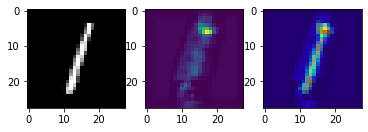

In [39]:
# Plotting the images
img = np.reshape(img, (28, 28))
cam_img = np.reshape(cam_img, (28, 28))

plt.figure(facecolor = "white")
plt.subplot(1, 3, 1)
plt.imshow(img, cmap = "gray")

plt.subplot(1, 3, 2)
plt.imshow(cam_img)

plt.subplot(1, 3, 3)
plt.imshow(img)
plt.imshow(cam_img, cmap = "jet", alpha = 0.5)

print("Prediction : ", pred)